In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

import math
import json
import os
import wandb
from datasets import FourierDataset
from utils import hash_dict, signal_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [261]:
# project_path = "whfourier/SyntheticSC"
project_path = "whfourier/FixedSyntheticSCSingleDeg"
experiment_name = "spectrum"

criteria = {
    "n": 10,
    "d": 5,
    "dataset_size_coef": 2,
    # "sample_seed": 44,
    "fix_seed": 5,
    "lr": 0.01,
    "training_method": ["normal", "alternate", "hashing", "EN-S", "EN"]
}

n = criteria["n"]
# dataset = FourierDataset(criteria["n"], k=criteria["n"], d=criteria["d"], n_samples=2**n, random_seed=criteria["fix_seed"],
#                         amp_sampling_method="constant")
k=criteria["d"]
dataset = FourierDataset(criteria["n"], k=k, n_samples=2**n, freq_seed=criteria["fix_seed"], random_seed=criteria.get("sample_seed", 11),
                        freq_sampling_method="single_deg", amp_sampling_method="constant")
int_freqs = dataset.get_int_freqs()


In [262]:
def get_model_dir(config, experiment_name):
    data_directory = os.environ.get("EXPERIMENT_DATA") if "EXPERIMENT_DATA" in os.environ else os.getcwd()

    keys_to_ignore = ["num_epochs"]
    config_to_hash = {k:v for k, v in config.items() if k not in keys_to_ignore}
    config_hash = hash_dict(config_to_hash)

    model_dir = f"{data_directory}/checkpoints/{experiment_name}/{config_hash}/"

    return model_dir

normal 25
alternate 25
hashing 25
EN-S 25
EN 25
{'normal': (501, 1024), 'alternate': (501, 1024), 'hashing': (501, 1024), 'EN-S': (501, 1024), 'EN': (501, 1024)}


(0.0, 1.0)

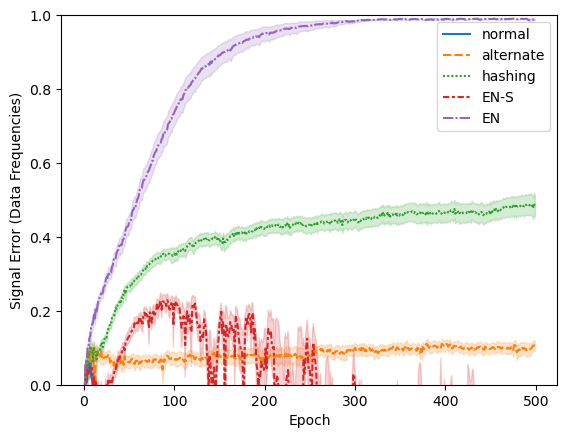

In [269]:
api = wandb.Api()
agg_spectrums = {}
all_spectrums = {}
logs = {}
epoch = 499
final_epoch = 500

for training_method in criteria["training_method"]:
    filters = {f'config.{k}': v for k, v in criteria.items()}
    filters["config.training_method"] = training_method
    # lambda
    if training_method == "EN":
        filters["config.hadamard_lambda"] = 1
    elif training_method == "hashing":
        filters["config.hadamard_lambda"] = 0.01
        filters["config.hashing_discount"] = 4
    elif training_method == "alternate":
        filters["config.hadamard_lambda"] = 1

    runs = api.runs(project_path, filters=filters)
    spectrum_list = []
    log_list = []
    print(training_method, len(runs))

    for run in runs:
        remove_from_train_config = ["hashing_discount", "dataset_size_coef", "val_size"]
        train_config = {k:v for k, v in run.config.items() if k not in remove_from_train_config}

        model_dir = get_model_dir(train_config, experiment_name)
        # Load Fourier Spectrums
        spectrum_file = f'{model_dir}/spectrums{epoch}.npy'
        if os.path.exists(spectrum_file):
            spectrum_list.append(np.array(np.load(spectrum_file, allow_pickle=True)))
            with open(f'{model_dir}/log{epoch}.json') as log:
                log_list.append(json.load(log))
        else:
            raise Exception(f"{spectrum_file} not found.", train_config)

    all_spectrums[training_method] = [spectrum * (k / 2**(n/2)) for spectrum in spectrum_list] 
    agg_spectrums[training_method] = np.mean(np.array(all_spectrums[training_method]), axis=0) 
    logs[training_method] = log_list
print({k: v.shape for k, v in agg_spectrums.items()})

# Plot logs
data = {}
for i, (method, log_list) in enumerate(logs.items()):
    data[method] = [log[epoch]["val_r2"]
                    for epoch in range(final_epoch)
                    for log in log_list]
    # all_data[method] = gaussian_filter1d(all_data[method], sigma=1)
    data["Epoch"] = [epoch
                        for epoch in range(final_epoch)
                        for log in log_list]

# g = sns.lineplot(data=data)
g = sns.lineplot(data=pd.DataFrame(data).set_index("Epoch"), errorbar="se")
g.set_xlabel("Epoch")
g.set_ylabel("Signal Error (Data Frequencies)")
g.set_ylim(0, 1)

## Evolution histogram

/tmp/ipykernel_31513/793028211.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


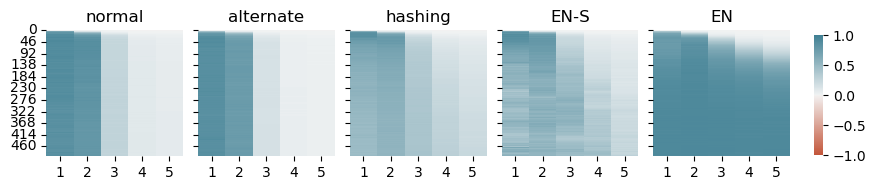

In [264]:
ground_spectrum = dataset.get_fourier_spectrum().reshape(1, -1)

ind_degrees = [(np.binary_repr(i).count('1'), i) for i in int_freqs]
deg_sorted_ind = [t[1] for t in sorted(ind_degrees)]
sorted_degs = [t[0] for t in sorted(ind_degrees)]
seps = [sorted_degs.index(i) if i in sorted_degs else 0 for i in range(2, criteria["d"] + 1)]

fig, axes = plt.subplots(1, len(agg_spectrums), figsize=(9, 2), sharey=True)
cbar_ax = fig.add_axes([.91, .2, .01, .6])

data_range = 1
cmap = sns.diverging_palette(20, 220, as_cmap=True)
for i, (method, spectrum) in enumerate(agg_spectrums.items()):
    sns.heatmap(pd.DataFrame(spectrum[:final_epoch, deg_sorted_ind] / ground_spectrum[0, deg_sorted_ind], columns=sorted_degs), 
                cmap=cmap, vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=False if i<len(agg_spectrums) -1 else True, cbar_ax=cbar_ax)
    axes[i].set_title(method)
    # axes[i].vlines(seps, *axes[i].get_ylim(), color="green", linestyles="dashed")
    # axes[i].hlines(spectrum["best"], *axes[i].get_xlim(), color="black", linestyles="dotted")
    axes[i].set_xticks([i + 0.5 for i in range(len(sorted_degs))], sorted_degs)
fig.tight_layout(rect=[0, 0, .9, 1])

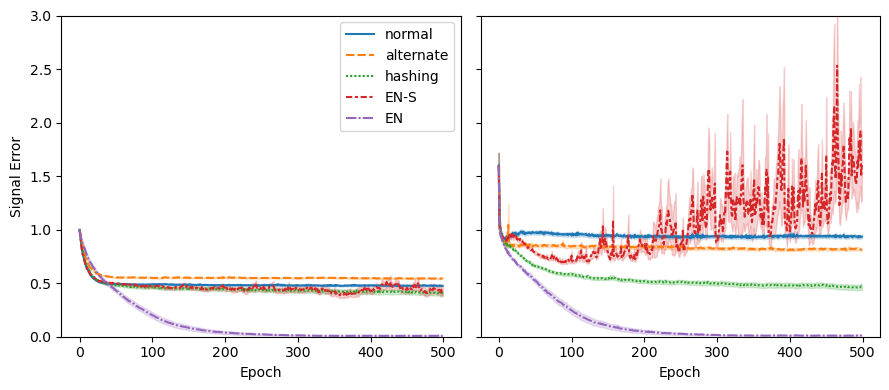

In [265]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
# Dataset Freqs
all_data = {}
for i, (method, spectrum_list) in enumerate(all_spectrums.items()):
    all_data[method] = [signal_error(ground_spectrum[0, int_freqs], spectrum[epoch, int_freqs]) 
                        for epoch in range(final_epoch)
                        for spectrum in spectrum_list]
    # all_data[method] = gaussian_filter1d(all_data[method], sigma=1)
    all_data["Epoch"] = [epoch
                        for epoch in range(final_epoch)
                        for spectrum in spectrum_list]
                        
g = sns.lineplot(data=pd.DataFrame(all_data).set_index("Epoch"), errorbar="se", ax=axes[0])
g.set_xlabel("Epoch")
g.set_ylabel("Signal Error")
g.set_ylim(0, 1)

# Spectrum
all_data = {}
for i, (method, spectrum_list) in enumerate(all_spectrums.items()):
    all_data[method] = [signal_error(ground_spectrum[0], spectrum[epoch]) 
                        for epoch in range(final_epoch)
                        for spectrum in spectrum_list]
    # all_data[method] = gaussian_filter1d(all_data[method], sigma=1)
    all_data["Epoch"] = [epoch
                        for epoch in range(final_epoch)
                        for spectrum in spectrum_list]

# g = sns.lineplot(data=data)
g = sns.lineplot(data=pd.DataFrame(all_data).set_index("Epoch"), errorbar="se", ax=axes[1], legend=False)
g.set_xlabel("Epoch")
g.set_ylabel("Signal Error")
g.set_ylim(0, 3)
fig.tight_layout()

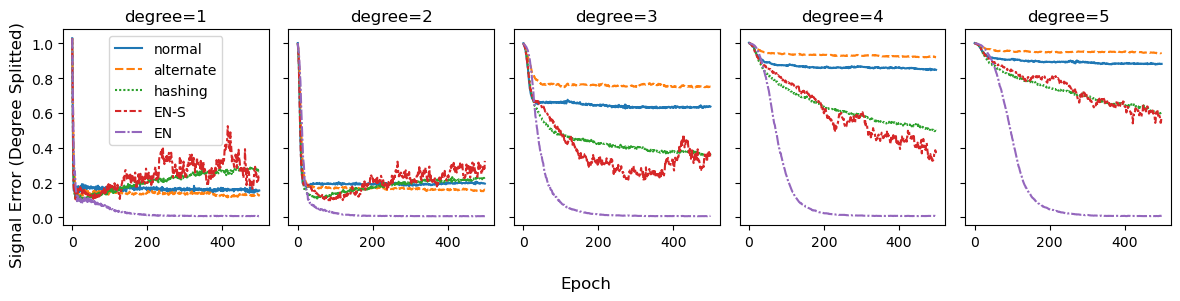

In [266]:
n_col = 5
count = criteria["d"] 
fig, axes = plt.subplots(math.ceil(count/n_col), n_col, figsize=(12, math.ceil(count/n_col)*(15/n_col)), sharey=True, sharex=True)

degree_array = np.array([np.binary_repr(i).count('1') for i in range(ground_spectrum.shape[1])])

for d in range(1, count+1):
    indices = np.where(degree_array == d)
    if count > n_col:
        ax = axes[(d-1)//n_col, (d-1)%n_col]
    else:
        ax = axes[d-1]
    
    data = {}
    for j, (method, spectrum) in enumerate(agg_spectrums.items()):
        data[method] = [signal_error(ground_spectrum[0, indices], spectrum[epoch, indices]) 
                        for epoch in range(final_epoch)]
        # data[method] = gaussian_filter1d(data[method], sigma=2)

    g = sns.lineplot(data=data, ax=ax, legend=False if d != 1 else True)
    # ax.set_ylim((0, 2))
    ax.set_title(f"degree={d}")

# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
fig.supxlabel('Epoch')
fig.supylabel('Signal Error (Degree Splitted)')
fig.tight_layout()

/tmp/ipykernel_31513/475234286.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


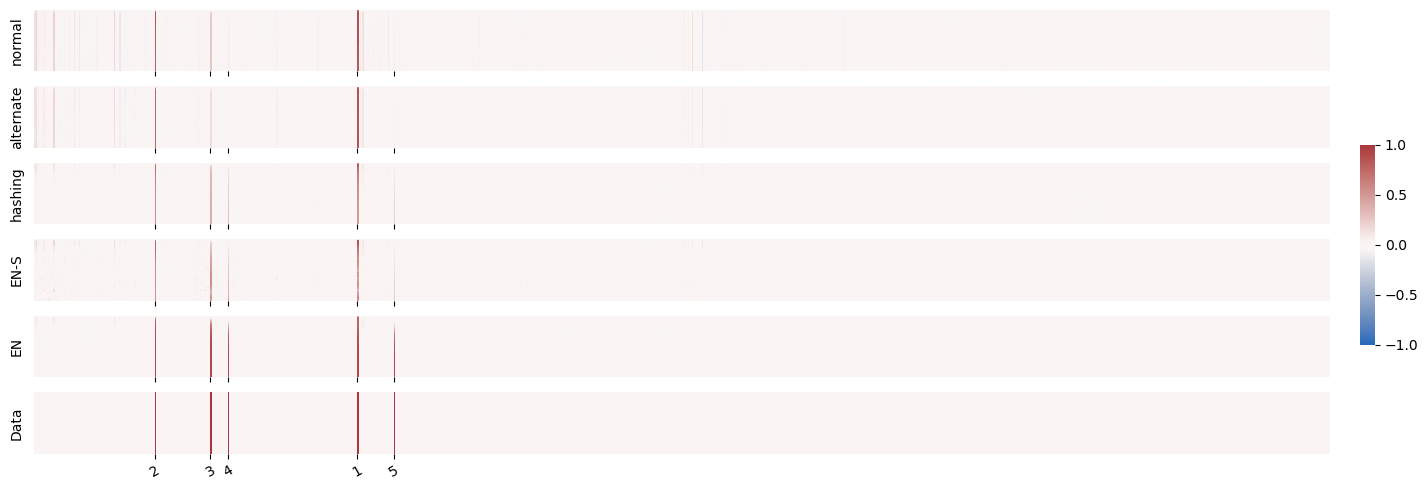

In [267]:
# Plot resltssignificant
fig, axes = plt.subplots(len(agg_spectrums)+1, 1, figsize=(15, len(agg_spectrums)*1), sharex=True)

data_range = 1
cbar_ax = fig.add_axes([.91, .3, .01, .4])
for i, (method, spectrum) in enumerate(agg_spectrums.items()):
    sns.heatmap(spectrum[:final_epoch, 1:], 
                cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=True if i==0 else False, cbar_ax=cbar_ax)
    axes[i].set_ylabel(method)

# GT
sns.heatmap(ground_spectrum[:, 1:], cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[-1], cbar=False)
axes[-1].set_ylabel("Data")

# Ticks
freq_degrees = [t[0] for t in ind_degrees]
for ax in axes:
    ax.set_xticks([x-1 for x in dataset.get_int_freqs()], freq_degrees, rotation=30)
    ax.set_yticks([])

fig.tight_layout(rect=[0, 0, .9, 1])